In [1]:
import tensorflow as tf

In [7]:
print('this is the current version of tensorflow i am using', tf.__version__)

this is the current version of tensorflow i am using 2.4.0


In [8]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [9]:
#Download dataset from URL
import pathlib
dataset_url = "https://newsimland.com/~destinnie-rickard/fish_photojpg.tar.gz"
data_dir = tf.keras.utils.get_file('fish_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

In [11]:
#Check connection with environment and fo an image count
image_count = len(list(data_dir.glob('*/*')))
print(image_count)

214


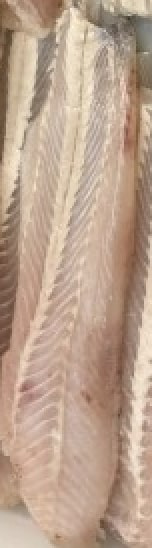

In [12]:
#Load an image from the agrade class
agrade = list(data_dir.glob('agrade/*'))
PIL.Image.open(str(agrade[0]))

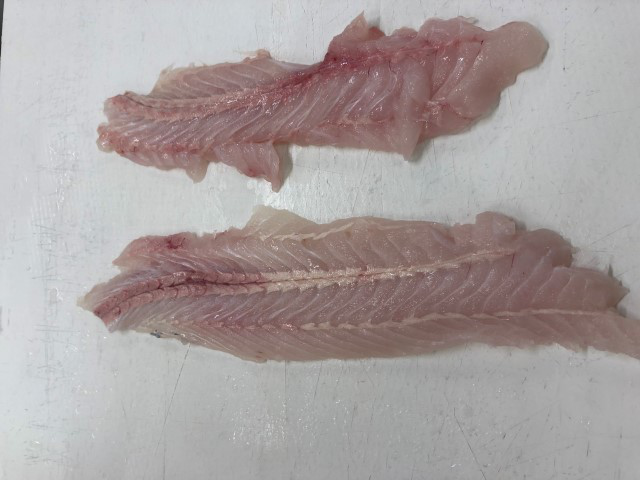

In [13]:
#Load an image from the ragged filet class
raggedfillet = list(data_dir.glob('raggedfillet/*'))
PIL.Image.open(str(raggedfillet[9]))

In [14]:
#Transform data to give all images the same pixles. Batch size represents the number of images it will train with in sets

batch_size = 32
img_height = 180
img_width = 180

In [15]:
#Split dataset to create training dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 214 files belonging to 2 classes.
Using 172 files for training.


In [16]:
#Split dataset again to create validation dataset

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 214 files belonging to 2 classes.
Using 42 files for validation.


In [17]:
#Print class names whihc are sub folders to parent folder

class_names = train_ds.class_names
print(class_names)

['agrade', 'raggedfillet']


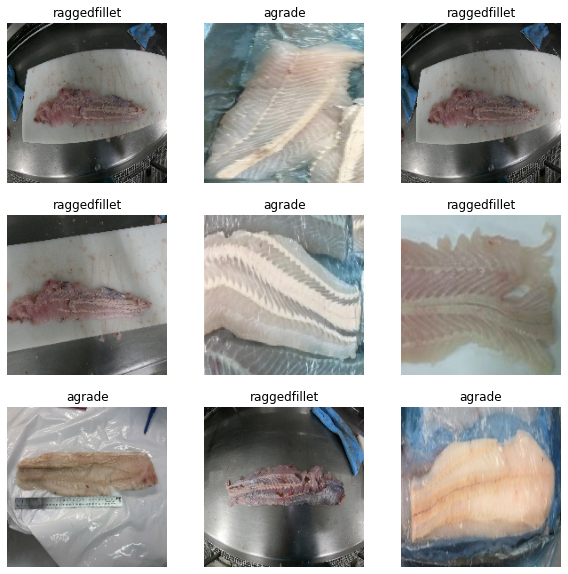

In [18]:
#Use Matplot library to visualise data from training dataset. Takes first 9 from first 32 images in training ds

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [19]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [20]:
#Use autotune for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [21]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [22]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.05214168 1.0


In [23]:
#Create a simple model using 3 layers

num_classes = 2

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [24]:
#Compile the model created

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [25]:
#Show a summary of the model
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)